In [2]:
from src.api.flipside_crypto import FlipsideCrypto
from src.misc.data import format_dtypes
import src.measures as measures

from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib widget

In [3]:
# see explore_slippage.ipynb for step-by-step explainations
# function for data formatting and calculation 

def format_swaps_df(df):
    return_columns = [
            "block_timestamp", "block_number", "tx_hash", 
            "amount0In", "amount0Out", "reserve0_before", "reserve0_after",
            "amount1In", "amount1Out", "reserve1_before", "reserve1_after", 
            ]

    # split events into Syncs and Swaps
    syncs_df = df.loc[df["event_name"] == "Sync"].reset_index(drop=True)
    swaps_df = df.loc[df["event_name"] == "Swap"].reset_index(drop=True)

    # on swaps_df, merge the sync from event before (gives reserves after swap)
    swaps_df["sync_event_index"] = swaps_df["event_index"] - 1
    dfs = pd.merge(
            left=swaps_df, 
            right=syncs_df[["tx_hash", "event_index", "event_inputs"]], 
            left_on=["tx_hash", "sync_event_index"], 
            right_on=["tx_hash", "event_index"], 
            how="left"
            )

    # ... formatting
    dfs = format_dtypes(dfs, {"event_inputs_x": dict, "event_inputs_y": dict})
    dtypes =  {
        "amount0In": int, 
        "amount0Out": int, 
        "amount1In": int, 
        "amount1Out": int,
        "reserve0": int, 
        "reserve1": int}
    dfs = format_dtypes(dfs, dtypes)
    dfs.rename(columns={"reserve0": "reserve0_after", "reserve1": "reserve1_after"}, inplace=True)

    # calc reserves before and price_before/after
    dfs["reserve0_before"] = dfs.apply(lambda row:  row["reserve0_after"] - row["amount0In"] + row["amount0Out"], axis=1)
    dfs["reserve1_before"] = dfs.apply(lambda row:  row["reserve1_after"] - row["amount1In"] + row["amount1Out"], axis=1)

    return dfs[return_columns]


def calc_prices_and_slippage(df, token0_decimals, token1_decimals):
    # calculates price_before/after, slippage, and tradesize_token0/1
    df["price_before"] = df.apply(lambda row: measures.calc_price_from_reserves(
        row["reserve0_before"], token0_decimals, row["reserve1_before"], token1_decimals
        ), axis=1)
    df["price_after"] = df.apply(lambda row: measures.calc_price_from_reserves(
        row["reserve0_after"], token0_decimals, row["reserve1_after"], token1_decimals
        ), axis=1)
    df["slippage"] = df.apply(lambda row: measures.calc_slippage(row["price_before"], row["price_after"]), axis=1)
    df["tradesize_token0"] =  (df["amount0In"] + df["amount0Out"]) / token0_decimals
    df["tradesize_token1"] =  (df["amount1In"] + df["amount1Out"]) / token1_decimals
    return df

In [4]:
ts = 1665187200  # 2022-10-08 00:00:00
ts = 1673136000  # 2023-01-08 00:00:00

# find_ts for block_number 16313916

pair = "USDC-ETH"
token0_decimals = 10**6
token1_decimals = 10**18

In [5]:
# pull data from flipside

# flipside = FlipsideCrypto("249f0e62-a575-4ddb-8ccd-b7618eb9d766")
# syncs_and_swaps = flipside.get_syncs_and_swaps("uniswap-v2", pair, ts, amount=-1, request_amount=1_000)
# dfs = pd.DataFrame(syncs_and_swaps)
# dfs.to_csv(f"{pair}_events_since_{ts}.csv")

from format_flipside_csv import load_events_from_flipside_csv
pair = "USDC-ETH"
block_number = 16313916
block_number = 16333882

filename = Path.cwd().joinpath("data", f"{pair}_{block_number}_new.csv")
dfs = load_events_from_flipside_csv(filename)

nan
nan


In [6]:
# format data and calculate slippage

dfs = format_swaps_df(dfs)
dfs = calc_prices_and_slippage(dfs, token0_decimals, token1_decimals)
dfs.head()

,block_timestamp,block_number,tx_hash,amount0In,amount0Out,reserve0_before,reserve0_after,amount1In,amount1Out,reserve1_before,reserve1_after,price_before,price_after,slippage,tradesize_token0,tradesize_token1
0,2023-01-04 14:00:23.000,16333883,0xc195bcb7d14a13895839494bdeab7022844f61d91b0f...,0,83054029,42437793566416,42437710512387,66398840913254403,0,33825707822189408069655,33825774221030321324058,1254.601790,1254.596871,0.000004,83.054029,0.066399
1,2023-01-04 14:00:59.000,16333886,0x6ca1a9fb3155103649a30fed486a9331e02acd0ff090...,120000000,0,42437710512387,42437830512387,0,95361040215116673,33825774221030321324058,33825678859990106207385,1254.596871,1254.603956,0.000006,120.000000,0.095361
2,2023-01-04 14:01:11.000,16333887,0xdc1fa0d1f611a67f1c2673dfe9a408ff95f3feb8da84...,0,122631547,42437830512387,42437707880840,98039627437123537,0,33825678859990106207385,33825776899617543330922,1254.603956,1254.596694,0.000006,122.631547,0.09804
3,2023-01-04 14:03:23.000,16333898,0x62c10c24931db196357ae6158c579455f12569e81524...,85188860,0,42437707880840,42437793069700,0,67697550792930889,33825776899617543330922,33825709202066750400033,1254.596694,1254.601724,0.000004,85.188860,0.067698
4,2023-01-04 14:03:35.000,16333899,0x2bc94a24fa84fe889643151b816bfe2fcd37f426b1f7...,0,476701212,42437793069700,42437316368488,381109782949023601,0,33825709202066750400033,33826090311849699423634,1254.601724,1254.573496,0.000022,476.701212,0.38111


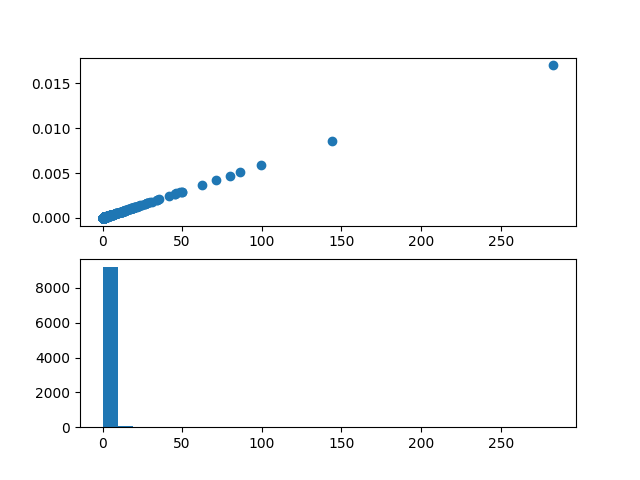

9264


In [7]:
fig, axs = plt.subplots(2,1)
axs[0].scatter(dfs["tradesize_token1"], dfs["slippage"])
axs[1].hist(dfs["tradesize_token1"], bins=30)
plt.show()
print(len(dfs))

123


/var/folders/xv/9qwc_ryj6l98nrg9pnn_zp7h0000gn/T/ipykernel_13847/3210320466.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df["slippage"]


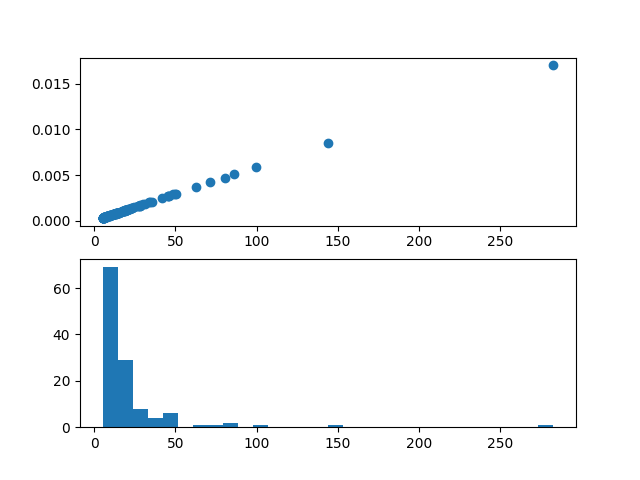

In [8]:
df = dfs[dfs["tradesize_token1"] > 5]
# df["target"] = df["slippage"] * df["tradesize_token1"].max() / df["slippage"].max()
df["target"] = df["slippage"]
print(len(df))

fig, axs = plt.subplots(2,1)
axs[0].scatter(df["tradesize_token1"], df["target"])
axs[1].hist(df["tradesize_token1"], bins=30)
plt.show()

In [9]:
# Fitting

from sklearn.model_selection import KFold
import numpy as np


In [11]:
for col in ["tradesize_token0", "tradesize_token1", "target"]:
    df[col] = df[col].astype(float)

/var/folders/xv/9qwc_ryj6l98nrg9pnn_zp7h0000gn/T/ipykernel_13847/3356282548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)


In [12]:
k = 10
kf = KFold(n_splits=k, shuffle=True)

degrees = [1, 2, 3, 4]

X = df["tradesize_token1"].values
t = df["target"].values

test_mse = []

for train_index, test_index in kf.split(X, t):
    split_mse = []
    for deg in degrees:
        
        w = np.polyfit(X[train_index], t[train_index], deg)
        y = np.polyval(w, X[test_index])
        
        mse = np.mean((t[test_index] - y)**2)
        split_mse.append(mse)
    
    test_mse.append(split_mse)

mean_mse = np.mean(test_mse, axis=0)
best_degree = degrees[mean_mse.argmin()]
print(f"Best degree: {best_degree}")
        

Best degree: 2


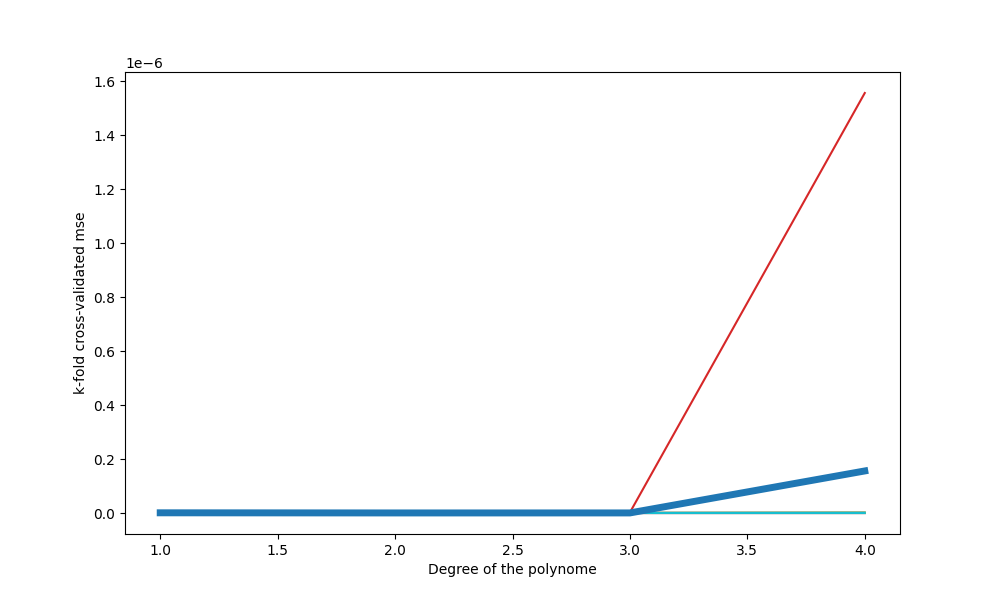

In [13]:
plt.figure(figsize=(10, 6))
for mse in test_mse:
    plt.plot(degrees, mse)
plt.plot(degrees, mean_mse, lw=5)
plt.xlabel("Degree of the polynome")
plt.ylabel("k-fold cross-validated mse")
plt.show()

deg: 1 	 coefficients: [-1.10966973e-05  5.98242517e-05]
deg: 2 	 coefficients: [3.66816549e-06 5.88305392e-05 4.55124358e-09]
deg: 3 	 coefficients: [ 9.53523194e-09  5.91912758e-05 -8.03161581e-10  1.47860260e-11]
deg: 4 	 coefficients: [ 5.92517135e-07  5.91128240e-05  1.43433955e-09 -3.47809014e-12
  3.99791351e-14]


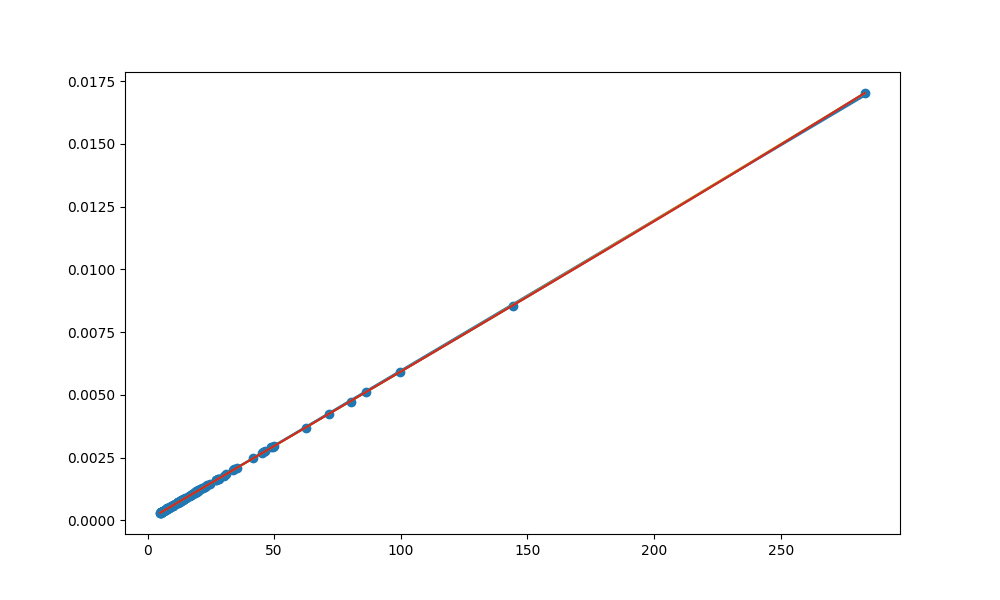

In [14]:
X_range = np.linspace(X.min(), X.max(), 1000)
plt.figure(figsize=(10, 6))

for deg in degrees:
    w = np.polyfit(X, t, deg=deg)  # w is sorted highest power first
    y_hat = np.polyval(w, X_range)


    plt.plot(X_range, y_hat)

    print(f"deg: {deg} \t coefficients: {w[::-1]}")  

plt.scatter(X, t)
plt.show()


Even though degree 2+ give better fits, but higher degrees dont contribute much compared to deg=1 (see coefficients)

So maybe better choose deg=1 model anyways for better explainability?